In [3]:
import torch
from model import ConditionalUNet
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import numpy as np

In [2]:
color_vocab = ["red", "green", "blue", "yellow", "orange", "purple", "pink", "black", "white", "cyan", "magenta"]
color_to_id = {c: i for i, c in enumerate(color_vocab)}

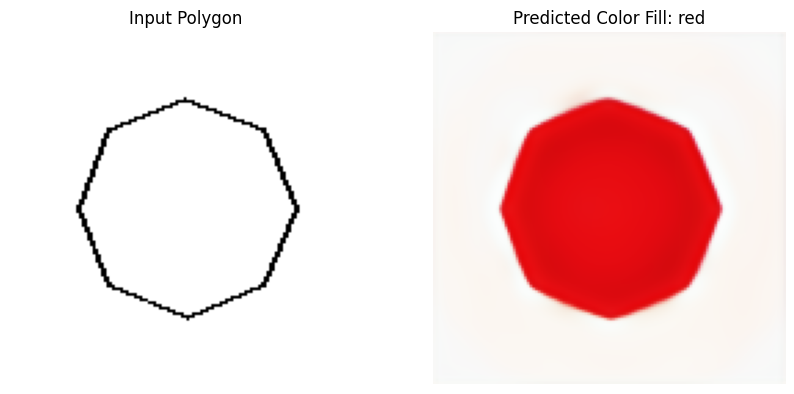

In [5]:
# Load the trained model
model = ConditionalUNet(color_vocab_size=len(color_vocab))
model.load_state_dict(torch.load("best_model/Final_R23_best_lr0.001_lossMSELoss_dim16_bilinearTrue.pth", map_location="cpu"))
model.eval()

# Utility: Load image from path
def load_image(path):
    img = Image.open(path).convert("RGB")
    return transforms.ToTensor()(img).unsqueeze(0)

# --- User Input Section ---

# Ask for polygon image path
img_path = input("Enter path to polygon image (e.g., dataset/validation/inputs/sample.png): ").strip()
if not os.path.exists(img_path):
    raise FileNotFoundError(f"File not found: {img_path}")

# Ask for color
color = input(f"Enter a color ({', '.join(color_vocab)}): ").strip().lower()
if color not in color_to_id:
    raise ValueError(f"Color '{color}' not in allowed list: {color_vocab}")

# Load image and color id
img = load_image(img_path)
color_id = torch.tensor([color_to_id[color]])

# --- Inference ---
with torch.no_grad():
    output = model(img, color_id).squeeze().permute(1, 2, 0).numpy()

# --- Display Results ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Input Polygon")
plt.imshow(img.squeeze().permute(1, 2, 0))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Predicted Color Fill: {color}")
plt.imshow(output)
plt.axis('off')
plt.show()

### Metric: Masked Pixel Accuracy with Tolerance

**Definition**:  
This metric measures how accurately the model predicts the RGB values of pixels *within the polygon regions* of an image. It compares each predicted pixel to the corresponding ground truth pixel and considers it correct if all three RGB channel values are within a small threshold (`tolerance`).

---

### Why Use This?
- It's robust to minor color variations.
- Focuses evaluation on relevant regions only.
- Simple and interpretable.


In [9]:
model = ConditionalUNet(color_vocab_size=len(color_vocab))
model.load_state_dict(torch.load("best_model/Final_R23_best_lr0.001_lossMSELoss_dim16_bilinearTrue.pth", map_location="cpu"))
model.eval()

# Setup
val_input_dir = "dataset/validation/inputs"
val_output_dir = "dataset/validation/outputs"
tolerance = 0.05

def load_image_tensor(path):
    img = Image.open(path).convert("RGB")
    return transforms.ToTensor()(img).unsqueeze(0)

def get_mask_from_tensor(tensor):
    return (tensor.squeeze(0).sum(dim=0) > 0).float()

def pixel_accuracy(pred, gt, mask, tolerance=0.05):
    pred = torch.tensor(pred).permute(2, 0, 1)  # [3, H, W]
    diff = torch.abs(pred - gt)
    match = (diff < tolerance).all(dim=0).float()
    return (match * mask).sum() / mask.sum()

# Function to find matching output
def find_matching_output(shape_name):
    for fname in os.listdir(val_output_dir):
        if shape_name in fname:
            return os.path.join(val_output_dir, fname)
    return None

# Main evaluation
accuracies = []
input_files = sorted(os.listdir(val_input_dir))

print(f"Evaluating {len(input_files)} samples...")

for fname in tqdm(input_files):
    input_path = os.path.join(val_input_dir, fname)

    # Infer shape name from input file
    shape_name = fname.split(".")[0].lower()

    # Find corresponding output image
    output_path = find_matching_output(shape_name)
    if output_path is None:
        print(f"⚠️ No match found for: {fname}")
        continue

    # Load input + GT
    img = load_image_tensor(input_path)
    gt = load_image_tensor(output_path).squeeze(0)  # [3, H, W]
    mask = get_mask_from_tensor(gt)

    # Use any fixed color_id (or infer from filename)
    color_name = output_path.split("/")[-1].split("_")[0].lower()
    color_id = torch.tensor([color_to_id[color_name]])

    with torch.no_grad():
        pred = model(img, color_id).squeeze().permute(1, 2, 0).numpy()

    acc = pixel_accuracy(pred, gt, mask, tolerance=tolerance)
    accuracies.append(acc.item())

# Final result
if len(accuracies) == 0:
    print("⚠️ No images were evaluated.")
else:
    mean_acc = np.mean(accuracies)
    print(f"\n✅ Average Pixel Accuracy (within polygon, tolerance={tolerance}): {mean_acc:.4f}")

Evaluating 4 samples...


100%|██████████| 4/4 [00:00<00:00, 14.90it/s]


✅ Average Pixel Accuracy (within polygon, tolerance=0.05): 0.8554
